In [1]:
import sys
from matplotlib import pyplot as plt
sys.path.append('../')
from dataset import *
from abstract_network import *
import time
from models import *
import os
# PCA
from sklearn.decomposition import PCA
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
dataset = MnistDataset(binary=False, one_hot=True)
c_dim = 5
x_in = tf.placeholder(tf.float32, [None] + dataset.data_dims)
c_in = tf.placeholder(tf.float32, [None, c_dim])

c_g = classifier(x_in, c_dim)
d_in = discriminator_cond(x_in, c_in)
d_g = discriminator_cond(x_in, c_g, reuse=True)

# Gradient penalty
epsilon = tf.random_uniform([], 0.0, 1.0)
c_hat = epsilon * c_in + (1 - epsilon) * c_g
d_hat = discriminator_cond(x_in, c_hat, reuse=True)

ddc = tf.gradients(d_hat, c_hat)[0]
ddc = tf.sqrt(tf.reduce_sum(tf.square(ddc), axis=1))
d_grad_loss = tf.reduce_mean(tf.square(ddc - 1.0) * 10.0)

d_loss_real = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_in, labels=tf.ones_like(d_in)))
d_loss_fake = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_g, labels=tf.zeros_like(d_g)))
g_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_g, labels=tf.ones_like(d_g)))
d_loss = d_loss_real + d_loss_fake
d_confusion = tf.reduce_mean(d_g) - tf.reduce_mean(d_in)
# d_loss = d_confusion #+ d_grad_loss
# g_loss = -tf.reduce_mean(d_g)

Extracting /home/zsj/PycharmProjects/AdversarialOptim/dataset/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/zsj/PycharmProjects/AdversarialOptim/dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/zsj/PycharmProjects/AdversarialOptim/dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/zsj/PycharmProjects/AdversarialOptim/dataset/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# optimal_c = tf.get_variable(shape=(100, 10), name='optimal_c')
# optimal_c_init = tf.
# optimal_c_class = tf.sigmoid(optimal_c)
# d_oc = tf.nn.sigmoid(discriminator_cond(x, optimal_c_class, reuse=True))
# d_oc_loss = -tf.reduce_mean(d_oc)
# input_train = tf.train.GradientDescentOptimizer(learning_rate=1e-2).minimize(d_oc_loss, var_list=optimal_c)

In [4]:
d_vars = [var for var in tf.global_variables() if 'dc_net' in var.name]
g_vars = [var for var in tf.global_variables() if 'c_net' in var.name]
d_train = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9).minimize(d_loss, var_list=d_vars)
g_train = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9).minimize(g_loss, var_list=g_vars)

In [5]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))
sess.run(tf.global_variables_initializer())

In [6]:
random_transform = np.random.normal(size=(10, c_dim))
noise_stddev = 0.2

def sample_train(size=128):
    bx, bc = dataset.next_labeled_batch(size)
    # bc = np.stack([np.max(bc[:, :5], axis=1), np.max(bc[:, 5:], axis=1)], axis=-1)
    bc = np.dot(bc, random_transform) + np.random.normal(size=(size, c_dim)) * noise_stddev
    return bx, bc

def sample_test(size=128):
    bx, bc = dataset.next_labeled_test_batch(size)
    bc = np.stack([np.max(bc[:, :5], axis=1), np.max(bc[:, 5:], axis=1)], axis=-1)
    bc = np.dot(bc, random_transform) + np.random.normal(size=(size, c_dim)) * noise_stddev
    return bx, bc

In [7]:
error = tf.reduce_mean(tf.abs(c_g - c_in))

In [8]:
def print_stats():
    bx, bc = sample_train(128)
    vals = sess.run([g_loss, d_loss, d_confusion, error], feed_dict={x_in: bx, c_in: bc})
    print("g_loss=%6.2f, d_loss=%6.2f, d_confusion=%6.2f, error=%6.2f" % tuple(vals))
print_stats()

g_loss=  1.01, d_loss=  1.58, d_confusion=  0.05, error=  0.99


In [9]:
# # Plots the gradients w.r.t. c
# dc_ = tf.gradients(d_, c_)[0]
# dc = tf.gradients(d, c)[0]
# tbx, tbc = sample_train(128)
# def plot_grad():
#     dc_val, dc_val_, bc_ = sess.run([dc, dc_, c_], feed_dict={x: tbx, c: tbc})
#     plot_args = {'interpolation':'none', 'cmap':'Greys'}
#     plt.figure(figsize=(10, 10))
#     plt.subplot(1, 4, 1)
#     plt.imshow(dc_val[:20], **plot_args)
#     plt.subplot(1, 4, 2)
#     plt.imshow(dc_val_[:20],**plot_args)
#     plt.subplot(1, 4, 3)
#     plt.imshow(bc_[:20],**plot_args)
#     plt.subplot(1, 4, 4)
#     plt.imshow(tbc[:20],**plot_args)
#     plt.show()

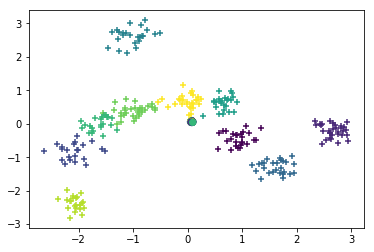

In [10]:
def plot_pca():
    bx, bc = dataset.next_labeled_batch(256)
    # bc = np.stack([np.max(bc[:, :5], axis=1), np.max(bc[:, 5:], axis=1)], axis=-1)
    c_g_val = sess.run(c_g, feed_dict={x_in: bx})
    bc_new = np.dot(bc, random_transform) + np.random.normal(size=(256, c_dim)) * noise_stddev
    joint = np.concatenate([c_g_val, bc_new], axis=0)
    joint_c = np.concatenate([bc, bc], axis=0)
    
    if c_dim > 2:
        pca = PCA(n_components=2)
        # c_g_val = pca.fit_transform(c_g_val)
        # bc_new = pca.fit_transform(bc_new)
        joint_new = pca.fit_transform(joint)
    
    #plt.subplot(1, num_plots, subplots[0])
    #plt.scatter(c_g_val[:, 0], c_g_val[:, 1], c=np.argmax(bc, axis=1))
    #plt.subplot(1, num_plots, subplots[1])
    #plt.scatter(bc_new[:, 0], bc_new[:, 1], c=np.argmax(bc, axis=1))
    plt.scatter(joint_new[:256, 0], joint_new[:256, 1], c=np.argmax(bc, axis=1), marker='o')
    plt.scatter(joint_new[256:, 0], joint_new[256:, 1], c=np.argmax(bc, axis=1), marker='+')
plot_pca()
plt.show()

In [ ]:
# def plot_disc(num_plots=1, subplot=1):
#     w = 20
#     cx, cy = np.meshgrid(np.linspace(-5, 5, w), np.linspace(-5, 5, w))
#     bc = np.stack([cx, cy], axis=-1)
#     bx = np.zeros(shape=(w*w, 28, 28, 1))
#     dval = sess.run(d_in, feed_dict={x_in: bx, c_in: bc.reshape([-1, 2])})

#     dval = np.reshape(dval, [w, w])
#     plt.subplot(1, num_plots, subplot)
#     plt.imshow(dval, interpolation='none', extent=[-5, 5, -5, 5], cmap='Greys')
# plot_disc()
# plt.show()

g_loss=  0.93, d_loss=  1.36, d_confusion= -0.27, error=  0.97


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:3315: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


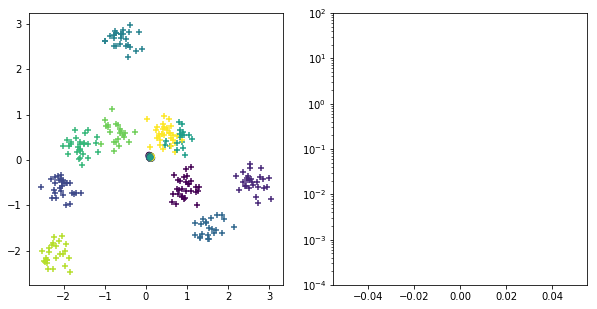

g_loss=  0.37, d_loss=  1.34, d_confusion= -1.05, error=  0.75


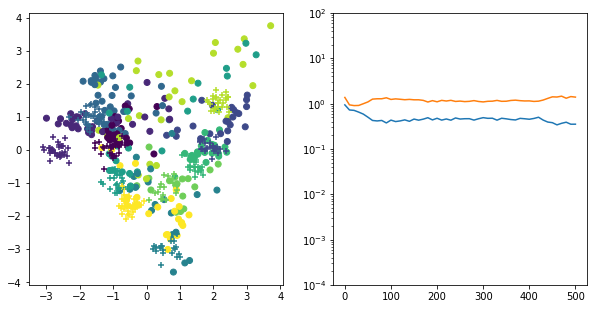

g_loss=  0.32, d_loss=  1.52, d_confusion= -0.45, error=  0.69


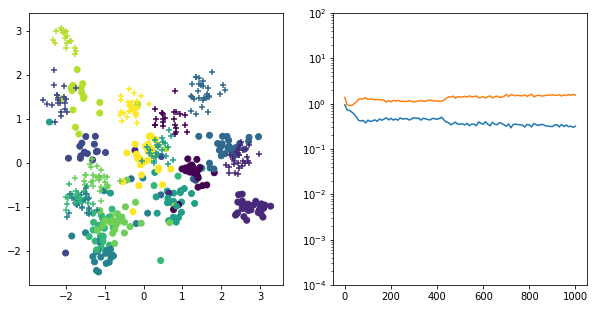

g_loss=  0.33, d_loss=  1.53, d_confusion= -0.37, error=  0.56


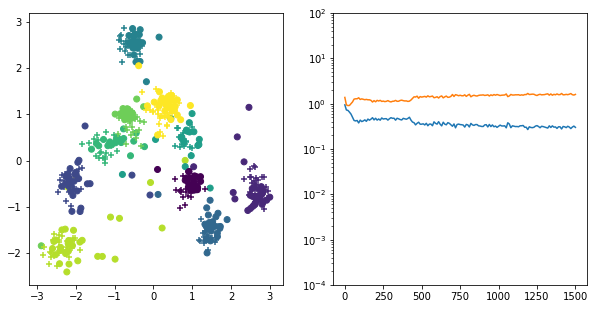

g_loss=  0.31, d_loss=  1.59, d_confusion= -0.26, error=  0.59


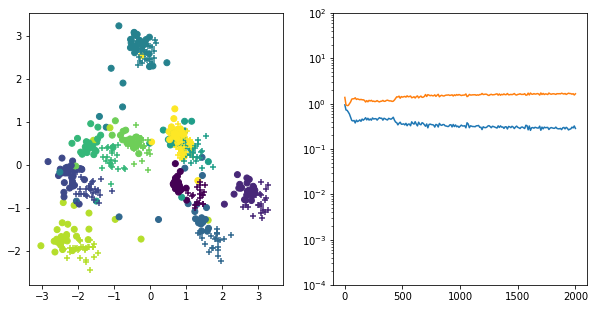

g_loss=  0.27, d_loss=  1.69, d_confusion= -0.15, error=  0.55


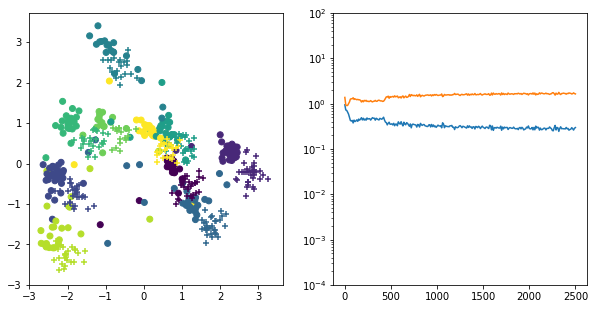

g_loss=  0.29, d_loss=  1.62, d_confusion= -0.19, error=  0.60


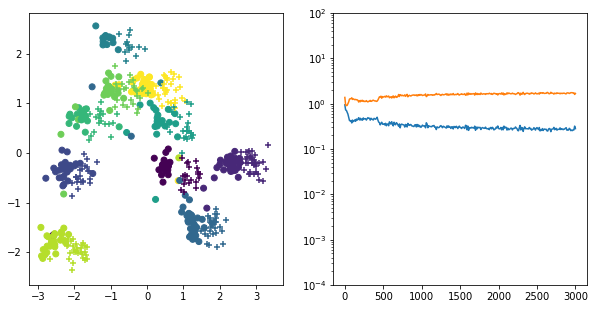

g_loss=  0.29, d_loss=  1.66, d_confusion= -0.16, error=  0.54


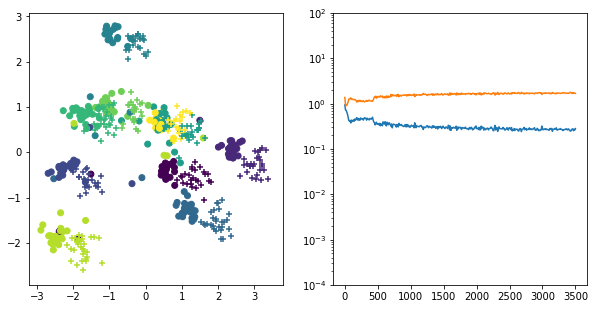

g_loss=  0.28, d_loss=  1.67, d_confusion= -0.10, error=  0.49


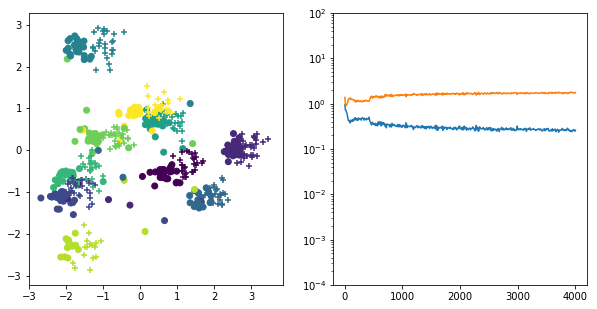

g_loss=  0.28, d_loss=  1.69, d_confusion= -0.06, error=  0.52


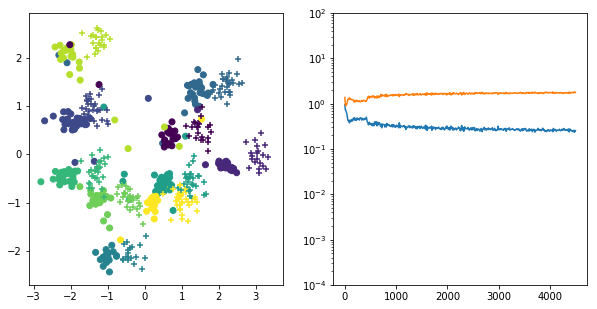

g_loss=  0.25, d_loss=  1.75, d_confusion= -0.03, error=  0.54


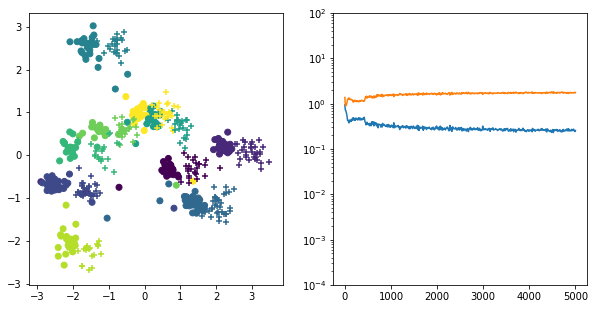

g_loss=  0.27, d_loss=  1.72, d_confusion= -0.08, error=  0.56


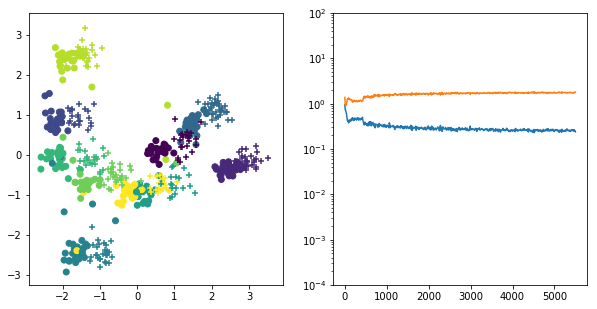

g_loss=  0.29, d_loss=  1.66, d_confusion= -0.06, error=  0.57


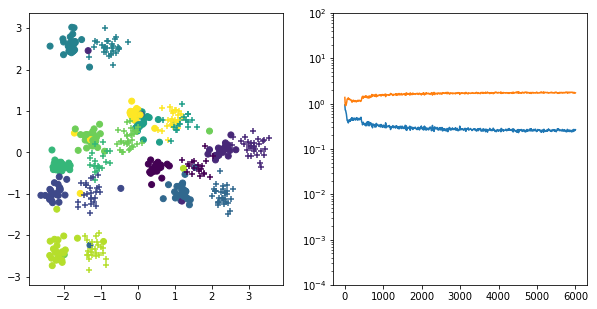

g_loss=  0.28, d_loss=  1.70, d_confusion= -0.04, error=  0.53


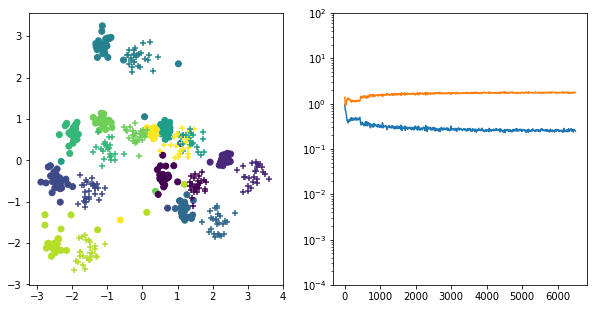

g_loss=  0.25, d_loss=  1.76, d_confusion= -0.02, error=  0.54


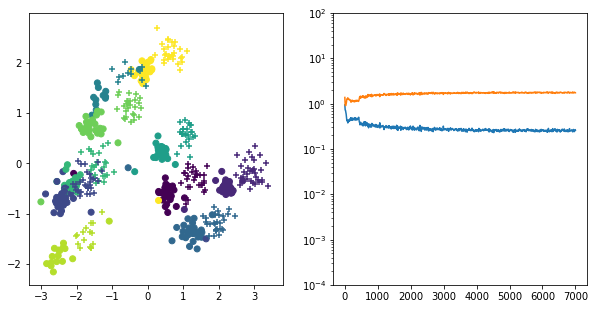

g_loss=  0.26, d_loss=  1.74, d_confusion= -0.01, error=  0.60


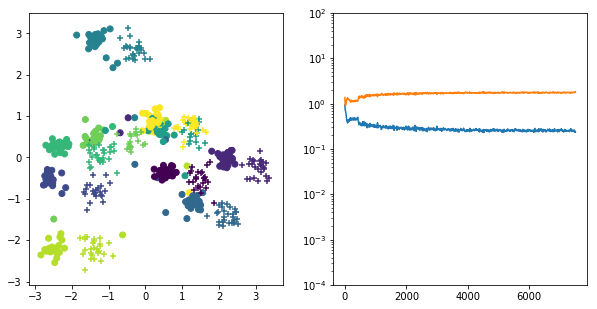

g_loss=  0.24, d_loss=  1.78, d_confusion= -0.01, error=  0.58


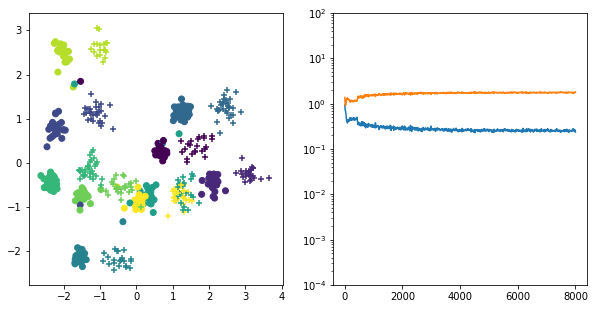

g_loss=  0.25, d_loss=  1.76, d_confusion= -0.02, error=  0.57


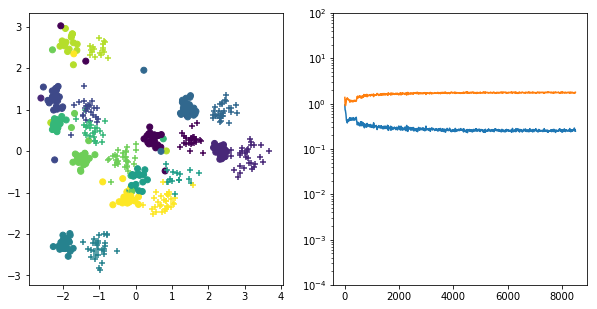

g_loss=  0.27, d_loss=  1.73, d_confusion=  0.02, error=  0.56


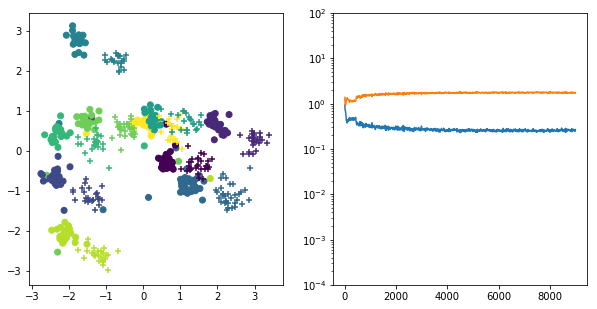

g_loss=  0.26, d_loss=  1.75, d_confusion=  0.03, error=  0.53


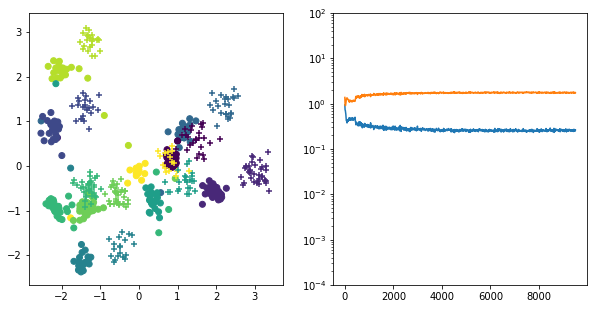

g_loss=  0.31, d_loss=  1.64, d_confusion= -0.03, error=  0.56


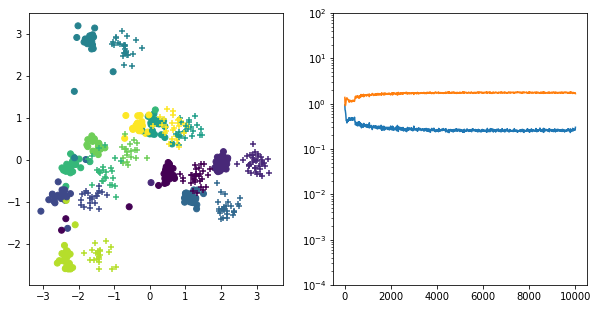

g_loss=  0.63, d_loss=  1.42, d_confusion= -0.01, error=  0.57


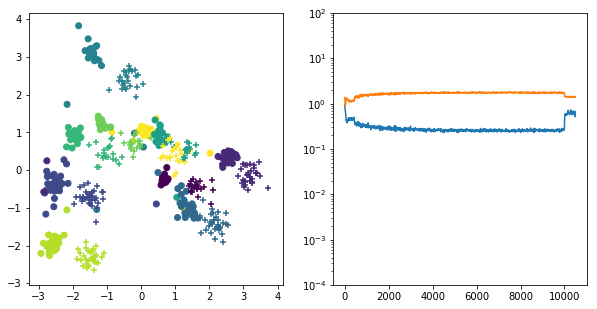

g_loss=  0.69, d_loss=  1.39, d_confusion= -0.03, error=  0.62


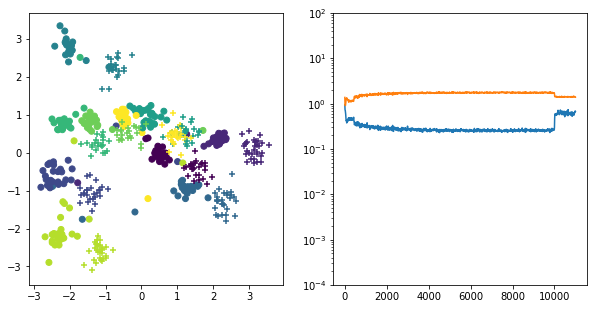

g_loss=  0.66, d_loss=  1.39, d_confusion= -0.01, error=  0.63


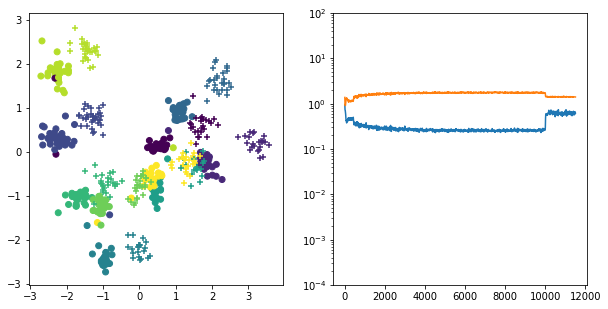

g_loss=  0.64, d_loss=  1.39, d_confusion= -0.01, error=  0.64


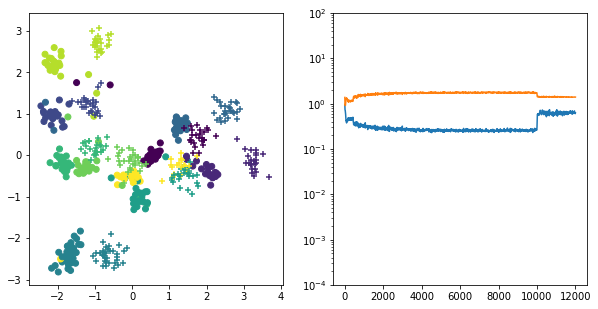

g_loss=  0.68, d_loss=  1.39, d_confusion= -0.00, error=  0.61


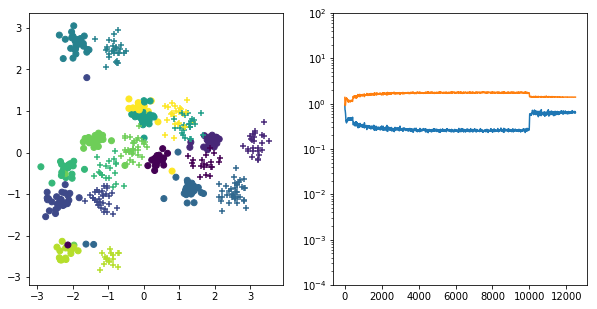

g_loss=  0.70, d_loss=  1.39, d_confusion= -0.00, error=  0.59


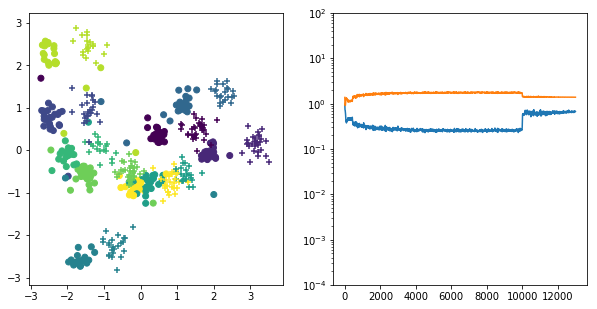

g_loss=  0.71, d_loss=  1.39, d_confusion= -0.00, error=  0.59


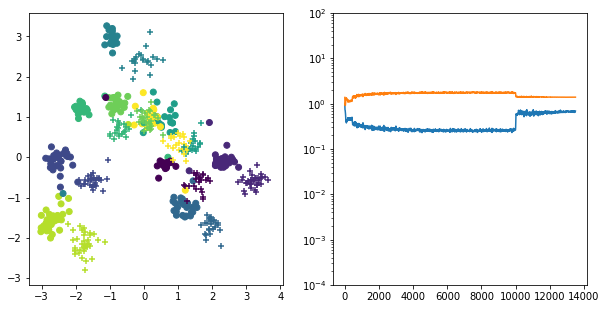

g_loss=  0.68, d_loss=  1.39, d_confusion= -0.00, error=  0.55


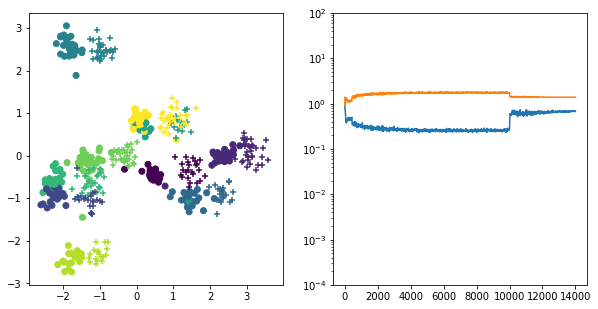

g_loss=  0.68, d_loss=  1.39, d_confusion= -0.00, error=  0.60


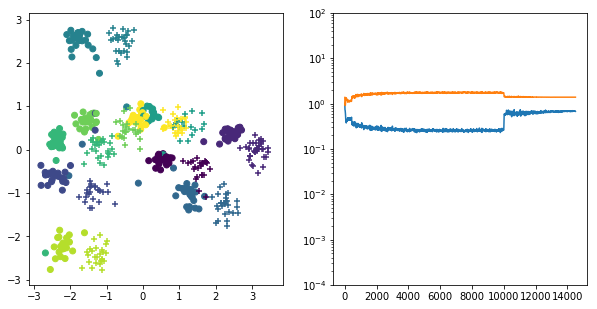

In [ ]:
d_rep = -1
g_rep = -1
iter_arr = []
d_loss_arr = []
g_loss_arr = []
np.random.seed(10)
logger = open('log.txt', 'w')
for idx in range(0, 2000000):
    if idx % 10000 == 0:
        d_rep_prev = d_rep
        while d_rep_prev == d_rep:
            d_rep = np.random.randint(1, 5) 
        g_rep_prev = g_rep
        while g_rep_prev == g_rep:
            g_rep = np.random.randint(1, 5)
        logger.write('%d %d\n' % (d_rep, g_rep))
    bx, bc = sample_train(128)
    for b_iter in range(min(g_rep, d_rep)):
        sess.run([d_train, g_train], feed_dict={x_in: bx, c_in: bc})
    if g_rep > d_rep:
        for g_iter in range(g_rep - d_rep):
            sess.run(g_train, feed_dict={x_in: bx, c_in: bc})
    if d_rep > g_rep:
        for d_iter in range(d_rep - g_rep):
            sess.run(d_train, feed_dict={x_in: bx, c_in: bc})
    if idx % 10 == 0:
        bx, bc = sample_train(256)
        vals = sess.run([g_loss, d_loss, d_confusion, error], feed_dict={x_in: bx, c_in: bc})
        iter_arr.append(idx)
        g_loss_arr.append(vals[0])
        d_loss_arr.append(vals[1])
        logger.write('%f %f %f\n' % (vals[0], vals[1], vals[2]))
        logger.flush()
        
    if idx % 500 == 0:
        print_stats()
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plot_pca()
        # plot_disc(3, 3)
        plt.subplot(1, 2, 2)
        plt.plot(iter_arr, g_loss_arr, label='g_loss')
        plt.plot(iter_arr, d_loss_arr, label='d_loss', hold=True)
        plt.yscale('log')
        plt.ylim([1e-4, 100])
        plt.show()
#         compare_grad()
#         make_plots()

In [ ]:
for idx in range(1, 1000):
    bx, bc = sample_train(128)
    sess.run([g_train], feed_dict={x_in: bx, c_in: bc})
    if idx % 100 == 0:
        print_stats()
        #plt.figure(figsize=(10, 5))
        plot_pca()
        plt.show()
        #plot_disc(3, 3)
        #plt.show()
#         compare_grad()
#         make_plots()

In [ ]:
bxc, bcc = dataset.next_labeled_batch(1)
def compare_grad(num_examples=1):
    for i in range(num_examples):
        w = 20
        cx, cy = np.meshgrid(np.linspace(0.0, 1.0, w), np.linspace(0.0, 1.0, w))
        cin = np.stack([cx, cy], axis=-1)

        bx, bc = bxc, bcc
        bc = np.stack([np.max(bc[:, :5], axis=1), np.max(bc[:, 5:], axis=1)], axis=-1)
        bc = np.tile(bc, [1000, 1])
        bc = label_noise(bc)

        bx = np.tile(bx, [w*w, 1, 1, 1])
        dval = sess.run(d, feed_dict={x: bx, c: cin.reshape(-1, 2)})

        dval = np.reshape(dval, [w, w])
        plt.subplot(1, 2, 1)
        plt.imshow(dval, interpolation='none', cmap='Greys')
        plt.subplot(1, 2, 2)
        plt.hist2d(bc[:, 0], bc[:, 1], bins=20, range=[[0, 1], [0, 1]], cmap='Greys')
        plt.show()

In [ ]:
np.random.randint(1,2)